In [30]:
import numpy as np
from matplotlib import pyplot as plt
import libs.MEVeS as S
import libs.AtomicConstants.Atom as A
import libs.Optimiser as Opt
import timeit
import plotly.express as px

pi_unicode = "\u03C0"
times_unicode = "\u00D7"

In [31]:
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 4}, "intermediate": {"n": 6, "J": 3/2}, 
                                                    "storage": {"n":6 ,"L": 0, "F" : 3}}}
atom = A.Cs(config)

protocol = 'Raman' # Memory protocol

eta_loop = 0.55

### Atomic vapour

In [32]:
T = 273.15+85 # temperature of the ensemble in K
vno = 30 # number of velocity classes to simulate.
L = 0.075 # length of the cell in m

OD_fudge_factor = 0.3

OD = OD_fudge_factor*atom.optical_depth(T, L)
print(f"OD (stationary) = {OD: .0f}")
ODeff = atom.effective_optical_depth(OD, T) # not needed for the simulation
print(f"Effective OD = {ODeff: .0f}")

n = 75 # number of space steps. Note these are not evenly spaced.

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno)) # initial spin wave

OD (stationary) =  43876
Effective OD =  963


### Pulse parameters

In [33]:
beam_radius = 100e-6 # in m
control_fudge_factor = 1/17

energy_readin = 404e-12 # in J
energy_readin = energy_readin * control_fudge_factor
print(f"Energy readin = {energy_readin*1e12} pJ")

energy_readout = 150e-12 # in J
energy_readout = energy_readout * control_fudge_factor
print(f"Energy readin = {energy_readout*1e12} pJ")

Energy readin = 23.764705882352942 pJ
Energy readin = 8.823529411764707 pJ


In [34]:
photon_pol = np.array([1, 0]) #should be normalised
control_pol = np.array([1, 0])

tau = np.sqrt(2)*330e-12 # 330ps FWHM in intensity

t0 = 3*tau # time of arrival of peak of photon wave packet.
tend = 15e-9 # end time of simulation
tbounds = np.array([0, tend]) # bounds of simulation time axis

m = 800 # number of time steps
t = np.linspace(0, tend, m) # time axis

detuning = 2*np.pi*2*atom.deltaHF
deltaS = detuning # detuning of the signal field
deltaC = detuning # detuning of the control field

tr = 12.5e-9 # storage time

## Solve 

In [35]:
HGmode_photon = 0
HGmode_control = 0

Einits = np.array(S.photon_HermiteG(t, t0, tau, HGmode_photon))[:, None] * photon_pol[None, :] # signal field initial condition
ControlW1 = S.photon_HermiteG(t, t0, tau, HGmode_control) # temporal shape of control field
ControlW1 = atom.set_energy_of_control_pulse(energy_readin, ControlW1, t, r=beam_radius)
Control_tp = (ControlW1)[:, None] * control_pol[None, :] # control field

solW1 = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)
Control_tzp = solW1.co_prop( Control_tp )
solW1.solve(Control_tzp, method='RK4-Ralston')
storageW1 = solW1.storage_efficiency(solW1.S, mi=-1)
leakedW1 = solW1.retrieval_efficiency(solW1.E, 0, 0)

Sout = solW1.S[-1]
Eout = solW1.E[:, -1]*np.sqrt(solW1.gamma) #leaked light after first storage attempt

Sout_summed = np.sum(Sout, axis = -1)
Eout_summed = np.sum(Eout, axis = -1)

### Second storage

In [38]:
### Loop through phases
phase_list = 2*np.pi*np.linspace(-0.1, 1.1, 20)
phase_list_dense = 2*np.pi*np.linspace(-0.1, 1.1, 200)

storage_eff_list = []

for phase in phase_list:

    ### Second storage attempt    
    Einits = Eout*np.sqrt(eta_loop)*np.exp(1j*phase) # signal field initial condition
    Sinits = Sout

    ControlW2 = S.photon_HermiteG(t, t0, tau, 0) # temporal shape of control field
    ControlW2 = atom.set_energy_of_control_pulse(energy_readin, ControlW2, t, r=beam_radius)
    Control_tp = (ControlW2)[:, None] * control_pol[None, :] # control field

    solW2 = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)
    Control_tzp = solW2.co_prop( Control_tp )
    solW2.solve(Control_tzp, method='RK4-Ralston')

    storageW2 = solW1.storage_efficiency(solW2.S, mi=-1)
    storage_eff_list.append( storageW2 )

parameters = np.polyfit(phase_list, np.array(storage_eff_list), 10)
max_eff = max(np.poly1d(parameters)(np.mod(phase_list_dense-min(phase_list), 2*np.pi) + min(phase_list)))
print(max_eff)

0.6970244565831043


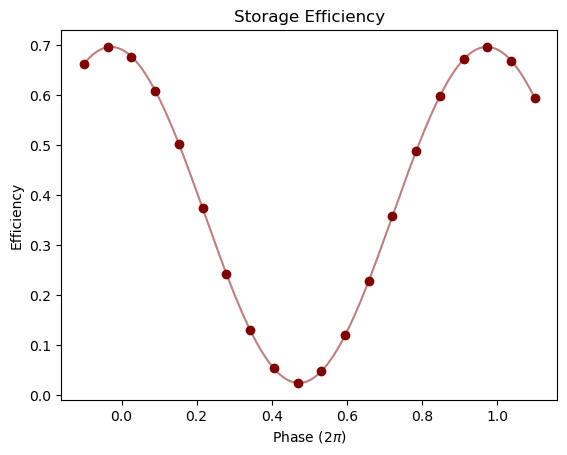

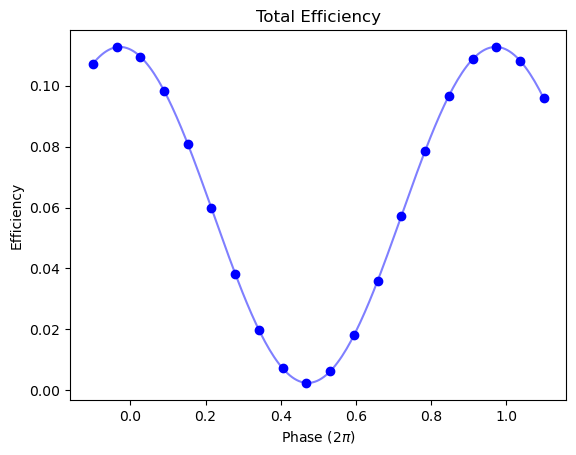

In [37]:
phase_list_dense = 2*np.pi*np.linspace(-0.1, 1.1, 200)

colour = '#800000ff'
plt.plot(phase_list/(2*np.pi), storage_eff_list, 'o', color=colour)
parameters = np.polyfit(phase_list, np.array(storage_eff_list), 10)
plt.plot(phase_list_dense/(2*np.pi),  np.poly1d(parameters)(np.mod(phase_list_dense-min(phase_list), 2*np.pi) + min(phase_list)), '-', color=colour, alpha=0.5)

plt.xlabel('Phase ($2 \pi$)')
plt.ylabel('Efficiency')
plt.title('Storage Efficiency')
plt.show()

colour = 'blue'
plt.plot(phase_list/(2*np.pi), total_eff_list, 'o', color='blue')
parameters = np.polyfit(phase_list, np.array(total_eff_list), 10)
plt.plot(phase_list_dense/(2*np.pi), np.poly1d(parameters)(np.mod(phase_list_dense-min(phase_list), 2*np.pi) + min(phase_list)), '-', color=colour, alpha=0.5)
plt.xlabel('Phase ($2 \pi$)')
plt.ylabel('Efficiency')
plt.title('Total Efficiency')
plt.show()

## Looping through HG modes

In [257]:
def mode_matrix(number_modes):
    """_summary_

    Args:
        number_modes (_type_): number of HG modes (signal and control) to create matrix
        eta_loop (_type_): loop transmission

    Returns:
       overlap_matrix:  overlap between E_leaked and E_in as a function of signal and control HG mode
       eff_W1_matrix:   storage efficiencies first read in process
       eff_W2_matrix:   storage efficiencies second read in process
    """

    leaked_E = np.zeros((number_modes+1, number_modes+1, 800), dtype = 'complex_') #HG mode signal, HG mode control, Efield, polarisation, 
    eff_W1_matrix = np.zeros((number_modes+1, number_modes+1))
    overlap_input_matrix = np.zeros((number_modes+1, number_modes+1))
    overlap_output_matrix = np.zeros((number_modes+1, number_modes+1, number_modes+1, number_modes+1))
    #eff_W2_matrix = np.zeros((number_modes+1, number_modes+1))
    test_matrix = np.zeros((number_modes+1, number_modes+1))
    phase_list = 2*np.pi*np.linspace(-0.1, 1.1, 20)
    #phase_list_dense = 2*np.pi*np.linspace(-0.1, 1.1, 200)

    for HGmode_photon in np.arange(number_modes+1):
        Einits = np.array(S.photon_HermiteG(t, t0, tau, HGmode_photon))[:, None] * photon_pol[None, :] # signal field initial condition
        for HGmode_control in np.arange(number_modes+1):
            #first storage attempt
            ControlW1 = S.photon_HermiteG(t, t0, tau, HGmode_control) # temporal shape of control field
            ControlW1 = atom.set_energy_of_control_pulse(energy_readin, ControlW1, t, r=beam_radius)

            solW1 = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)
            Control_tzp = solW1.co_prop((ControlW1)[:, None] * control_pol[None, :])
            solW1.solve(Control_tzp, method='RK4-Ralston')

            eff_W1_matrix[HGmode_photon, HGmode_control] = solW1.storage_efficiency(solW1.S, mi=-1)

            #Sout = solW1.S[-1]
            #Eout = solW1.E[:, -1]*np.sqrt(solW1.gamma) #leaked light after first storage attempt, in real dimensions
            leaked_E[HGmode_photon, HGmode_control,:] = solW1.E[:, -1,0]*np.sqrt(solW1.gamma)

            photon_norm = max(pow(np.abs(solW1.E[:, 0, 0]),2))
            control_norm = pow(np.max(np.abs(ControlW1)), 2) # normalise factor for plotting control field
            fig, ax = plt.subplots(figsize=(9.5, 3.5))
            ax.plot(t*1e9, pow(np.abs(solW1.E[:, 0, 0]),2)/photon_norm, color='#fde0ddff', linestyle='-')
            ax.fill_between(t*1e9, np.abs(solW1.E[:, 0, 0])**2/photon_norm , color='#fde0ddff', alpha=0.8, label='Input photon')
            ax.plot(t*1e9, pow(np.abs(solW1.E[:, -1, 0]),2)/photon_norm, color='#fa9fb5ff', linestyle='-')
            ax.fill_between(t*1e9, np.abs(solW1.E[:, -1, 0])**2 /photon_norm, color='#fa9fb5ff', alpha=0.5, label='Output photon')
            ax.plot(t*1e9, np.abs(ControlW1)**2/control_norm, color='#c51b8aff', label='Control field', alpha = 0.5)
            ax.set_ylabel('Normalised intensity', color='k')
            ax.set_xlabel('time (ns)')
            plt.legend(loc='upper center', fancybox=True, shadow=True)
            plt.show()



            overlap_input_matrix[HGmode_photon, HGmode_control] = np.abs(np.trapz(solW1.E[:, -1,0]*np.sqrt(solW1.gamma)*Einits[:,-1][0], x = t))**2
        
        for i in range(leaked_E.shape[0]):
            for j in range(leaked_E.shape[1]):
                for k in range(leaked_E.shape[0]):
                    for l in range(leaked_E.shape[1]):
                        product = leaked_E[i, j, :] * np.conj(leaked_E[k, l, :])
                        integral = np.trapz(product, x=t)
                        overlap_output_matrix[i, j, k, l] = np.abs(integral)**2    
        flattened_size = (number_modes + 1) ** 2
        overlap_2d_matrix = overlap_output_matrix.reshape(flattened_size, flattened_size)

       
    return overlap_input_matrix, leaked_E, overlap_output_matrix, overlap_2d_matrix



    



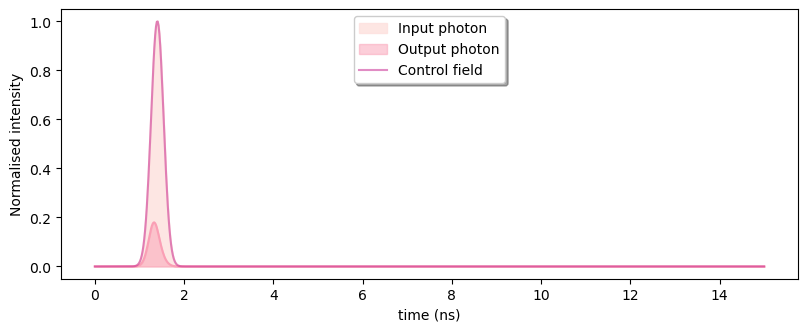

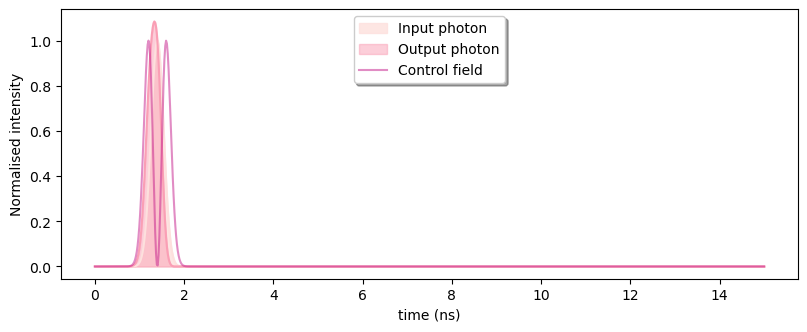

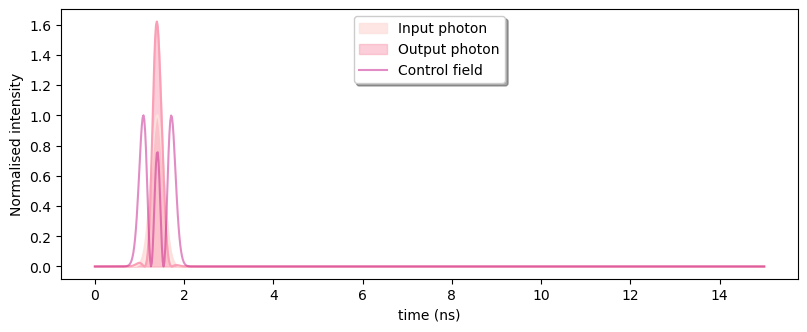

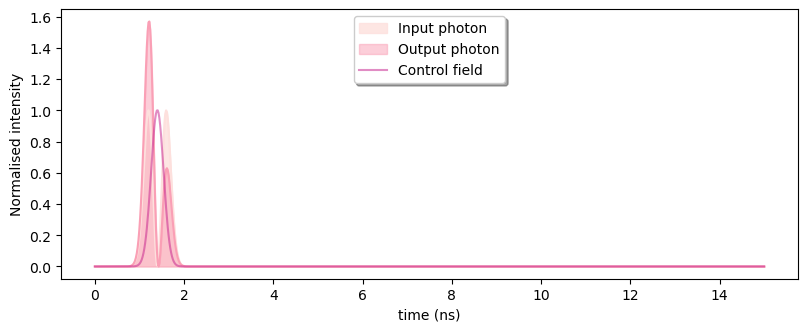

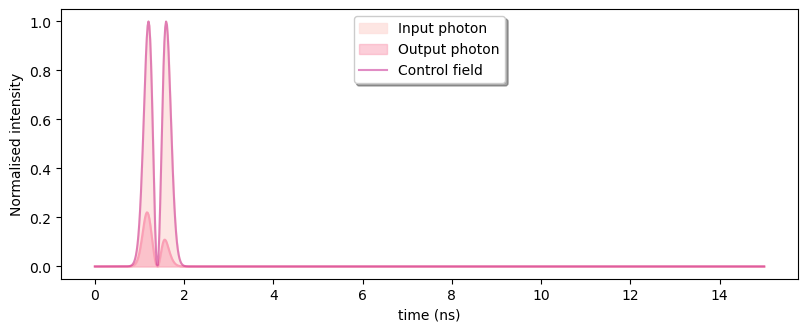

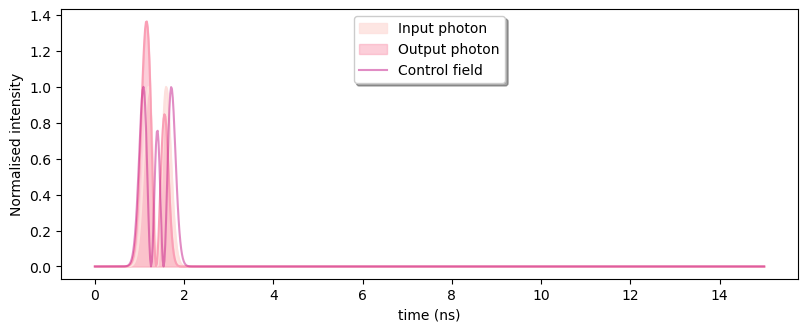

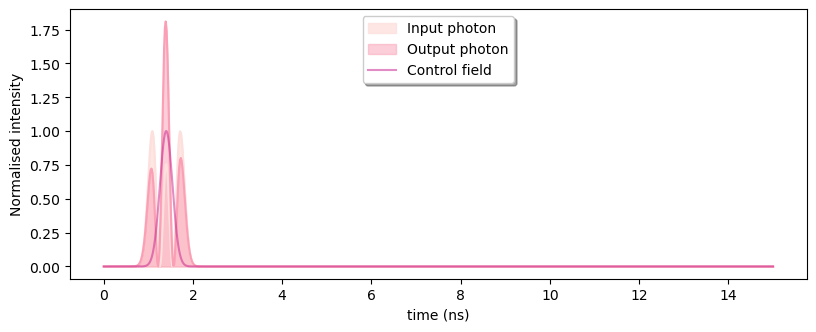

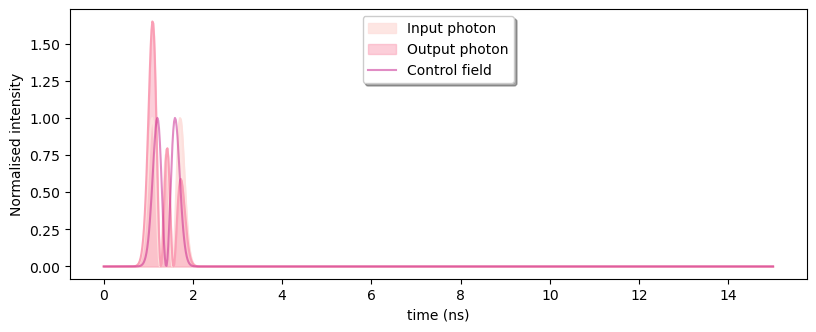

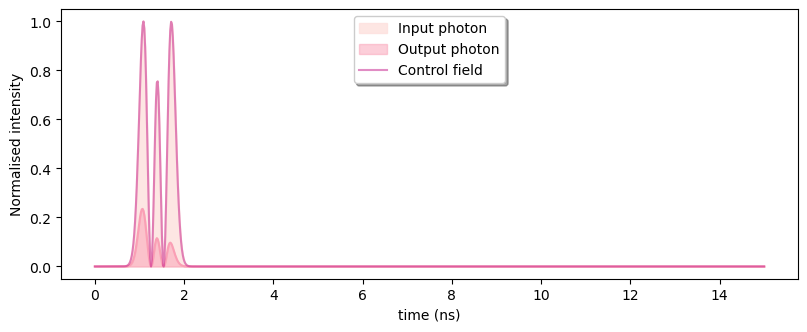

In [258]:
overlap_input, leaked_matrix, overlap_output, overlap_2d_matrix= mode_matrix(2)


In [224]:
overlap_input

array([[0., 0.],
       [0., 0.]])

In [223]:
overlap_2d_matrix

array([[0.02632215, 0.18000858, 0.03812689, 0.00292953],
       [0.18000858, 1.27138009, 0.34680177, 0.03011714],
       [0.03812689, 0.34680177, 1.22716736, 0.17190847],
       [0.00292953, 0.03011714, 0.17190847, 0.02637018]])

In [211]:
E_leaked_01 = leaked_matrix[0][1]
E_leaked_00 = leaked_matrix[0][0]


np.abs(np.trapz(E_leaked_00*E_leaked_01, x =t))**2

0.179152607712472